In [1]:
import datasets
from transformers import BertForSequenceClassification, BertModel, BertTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import numpy as np
import torch

/usr/lib/python3/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-24 23:17:30.418170: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 23:17:31.323612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load and Analyze Data

In [2]:
data = datasets.load_dataset("tweet_eval", "sentiment")
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}

### Plotting label distribution of the splits.

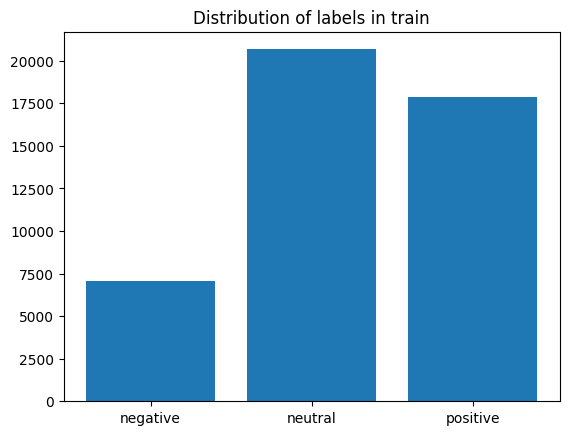

train [7093, 20673, 17849]


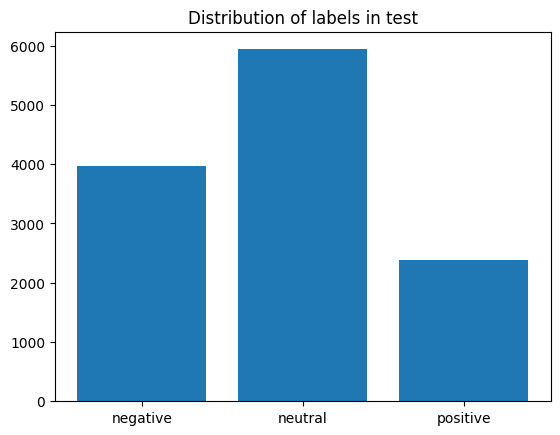

test [3972, 5937, 2375]


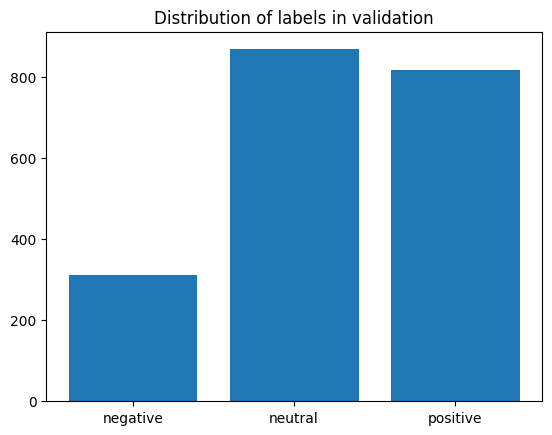

validation [312, 869, 819]


In [4]:
splits = ['train', 'test', 'validation']
#split = splits[2]

def plot_distr(split):
    fig = plt.figure()
    label_counts = data[split]['label']
    label_counts = [label_counts.count(i) for i in range(3)]
    plt.bar(['negative', 'neutral', 'positive'], label_counts)
    plt.title('Distribution of labels in ' + split)
    plt.show()

    print(split, label_counts)
    
for s in splits:
    plot_distr(s)

### Get splits

In [5]:
X_train, y_train = data['train']['text'], data['train']['label']
X_val, y_val = data['validation']['text'], data['validation']['label']
X_test, y_test = data['test']['text'], data['test']['label']

### Downsampling the splits

In [6]:
def down_sample(X, y):
    label_count = [y.count(i) for i in range(3)]
    min_count = min(label_count)
    
    XY = np.array(list(zip(X, y)))
    
    downsampled = []
    for i in range(3):
        label = XY[XY[:, 1] == str(i)]
        np.random.shuffle(label)
        downsampled.append(label[:min_count])
    
    downsampled = np.concatenate(downsampled)
    np.random.shuffle(downsampled)
    
    return list(downsampled[:, 0]), [int(x) for x in downsampled[:, 1]]

In [7]:
X_train_sample, y_train_sample = down_sample(X_train, y_train)
X_val_sample, y_val_sample = down_sample(X_val, y_val)
X_test_sample, y_test_sample = down_sample(X_test, y_test)

### Plot label distributions after downsampling

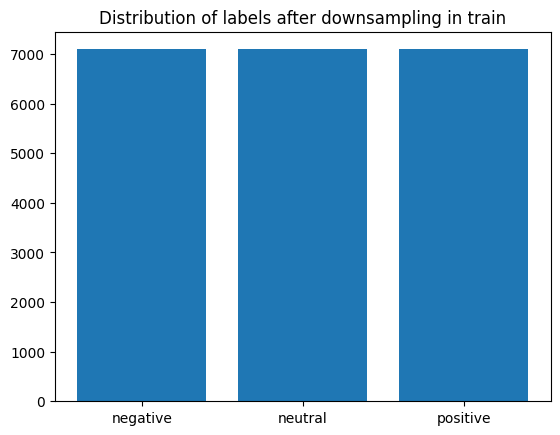

train [7093, 7093, 7093]


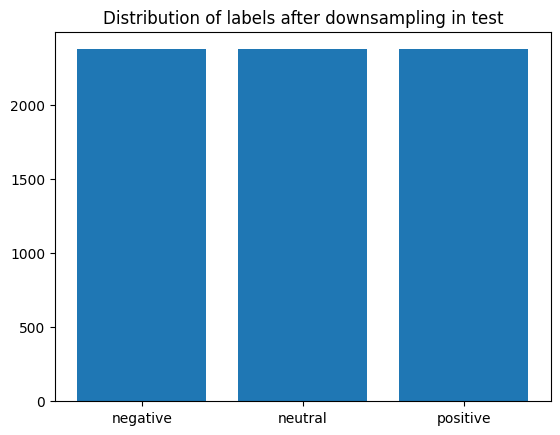

test [2375, 2375, 2375]


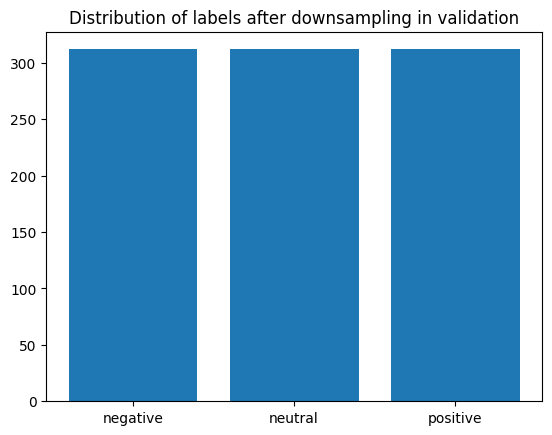

validation [312, 312, 312]


In [8]:
def plot_distr_sample(X, y, split):
    fig = plt.figure()
    label_counts = y
    label_counts = [label_counts.count(i) for i in range(3)]
    plt.bar(['negative', 'neutral', 'positive'], label_counts)
    plt.title('Distribution of labels after downsampling in ' + split)
    plt.show()

    print(split, label_counts)
    
plot_distr_sample(X_train_sample, y_train_sample, 'train')
plot_distr_sample(X_test_sample, y_test_sample, 'test')
plot_distr_sample(X_val_sample, y_val_sample, 'validation')


## Finetune BERT Model

### Initialize the model

In [9]:
bertsc = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


train_encodings = tokenizer(X_train_sample, truncation=True, padding=True)
val_encodings = tokenizer(X_val_sample, truncation=True, padding=True)
test_encodings = tokenizer(X_test_sample, truncation=True, padding=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prepare data and metrics

In [10]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = TweetDataset(train_encodings, y_train_sample)
val_dataset = TweetDataset(val_encodings, y_val_sample)
test_dataset = TweetDataset(test_encodings, y_test_sample)

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def _compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='macro')
    acc = accuracy_score(labels, pred)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

### Training

In [12]:
train_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./results/logs',
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    fp16=True
    
)

trainer = Trainer(
    model=bertsc,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=_compute_metrics
)

trainer.train()

 20%|██        | 2660/13300 [08:30<32:04,  5.53it/s]

{'loss': 0.8028, 'grad_norm': 10.687106132507324, 'learning_rate': 4.1574218750000006e-05, 'epoch': 1.0}


                                                    
 20%|██        | 2660/13300 [08:34<32:04,  5.53it/s]

{'eval_loss': 0.702452540397644, 'eval_accuracy': 0.6987179487179487, 'eval_f1': 0.6922299641525091, 'eval_precision': 0.7028864956366926, 'eval_recall': 0.6987179487179486, 'eval_runtime': 3.4708, 'eval_samples_per_second': 269.68, 'eval_steps_per_second': 33.71, 'epoch': 1.0}


 22%|██▏       | 2944/13300 [09:41<39:28,  4.37it/s]   

### Plot training and validation history